In [19]:
from google.colab import drive
drive.mount('/content/gdrive')
svpath = '/content/gdrive/My Drive'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# U-net Architecture 

In [0]:
# sub-parts of the U-Net model

import torch
import torch.nn as nn
from torch.nn import init
import numpy as np

def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )


def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )

class unet(nn.Module):
  def __init__(self, useBN=True):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1   = add_conv_stage(3, 32, useBN=useBN)
    self.conv2   = add_conv_stage(32, 64, useBN=useBN)
    self.conv3   = add_conv_stage(64, 128, useBN=useBN)
    self.conv4   = add_conv_stage(128, 256, useBN=useBN)
    #self.conv5   = add_conv_stage(256, 512, useBN=useBN)
    #self.conv6   = add_conv_stage(512, 1024, useBN=useBN)
    
    # Upgrade tages
    #self.conv5m = add_conv_stage(1024, 512, useBN=useBN)
    self.conv4m = add_conv_stage(512, 256, useBN=useBN)
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    #self.upsample65 = upsample(1024, 512)
    self.upsample54 = upsample(512, 256)
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)
 
    self.out_layer = nn.Conv2d(32, 8, 3, 1, 1) # for 8 classes
    self.softmax = nn.Softmax(dim=1) # for classification 
    
    
    ## weight initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()
        #kaiming init
        #init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        #init.normal_(m.weight.data, 0.0, 0.02)

   
    

  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
    conv3m_out = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out = self.conv1m(conv2m_out_)

    ## Design your last layer & activations
    out = self.out_layer(conv1m_out)
    out = self.softmax(out)
    return out

# Dice Loss

In [0]:
from torch.nn import functional as F


def dice_loss(probas,true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Args:
        true: a tensor of shape [B, C, H, W] ground truth.
        probas: a tensor of shape [B, C, H, W]. Corresponds to the raw output.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """ 
    dims = (0,2,3)
    intersection = torch.sum(probas * true, dims)
    cardinality = torch.sum(probas + true, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

# Utility

In [0]:
def one_hot_encoding(mask):
  '''input: H x W output:  (8 x H x W) '''
  mask_onehot = np.zeros((8,256,320))
  #one-hot encoding for mask
  list_mapping = [0,32,64,96,128,160,192,224]
  for i in range(len(list_mapping)):
    label = mask==list_mapping[i]
    label.astype(np.float)
    mask_onehot[i] = label
  return mask_onehot

def reverse_one_hot_encoding(mask):
  '''input: (8 x H x W) output: H x W'''
  list_mapping = [0,32,64,96,128,160,192,224]
  mask = np.argmax(mask, axis=0)
  for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
      mask[i,j] = list_mapping[mask[i,j].astype(np.int)]
  return mask

def reverse_Normalize(array):  #For colorization
  '''input: (C x H x W) ndarray output: H x W or H x W x C '''
  array = array.transpose((1,2,0))
  array = (array+1)/2
  return array

# Data Loader and Hyperparameters

In [0]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import functional
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline


class ToTensor(object):
    """Convert ndarrays in sample to Tensors. Modifiy code from pytorch offical website"""
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        # swap color axis because  # numpy image: H x W x C # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        #mask = np.expand_dims(mask, axis=0)
        return {'image': torch.from_numpy(image).type(torch.FloatTensor),
                'mask': torch.from_numpy(mask).type(torch.FloatTensor)}

class Normalize(object):
    #modified scource code from Pytorch official source code
    """Normalize a tensor image with mean and standard deviation.
    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
    """
    '''input[channel] = (input[channel] - mean[channel]) / std[channel]'''

    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.std = std
        self.inplace = inplace    
    def __call__(self, sample):
        """
        Args:
            sample['image'] (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            sample: dict with Normalized Tensor image.
        """
        image, mask = sample['image'], sample['mask']
        image = functional.normalize(image, self.mean, self.std, self.inplace)
        return {'image': image,'mask': mask}
      
class RandomVerticalFlip(object):
      #modified scource code from Pytorch official source code
      """Verucal flip the given tensor randomly with a given probability.
      Args:
          p (float): probability of the image being flipped. Default value is 0.5
      """
      def __init__(self, p=0.5):
        self.p = p
      def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        if random.random() < self.p:
          return {'image' : torch.flip(image, [1]) ,'mask': torch.flip(mask, [1])}
        return sample
      
class RandomHorizontalFlip(object):
      #modified scource code from Pytorch official source code
      """Horizontal flip the given tensor randomly with a given probability.
      Args:
          p (float): probability of the image being flipped. Default value is 0.5
      """
      def __init__(self, p=0.5):
        self.p = p
      def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        if random.random() < self.p:
          return {'image' : torch.flip(image, [2]) ,'mask': torch.flip(mask, [2])}
        return sample
  
class ImageDataset(Dataset):
    def __init__(self, input_dir,transform=None):
      self.root = input_dir
      #Get all subfolders
      self.image_folders = [os.path.join(self.root, o) 
                            for o in os.listdir(self.root) if os.path.isdir(os.path.join(self.root,o))]
      self.length = len(self.image_folders)
      self.transform = transform
    def __len__ (self):
      return self.length
      
    def __getitem__(self,idx):
      working_folder = os.path.join(self.root,self.image_folders[idx])
      for filename in os.listdir(working_folder):
        if filename.endswith('.png'):
          mask_name = os.path.join(working_folder,filename)
        elif filename.endswith('.jpg'):
          img_name = os.path.join(working_folder,filename)
      image = io.imread(img_name)
      mask =io.imread(mask_name)
      #one-hot encoding for mask
      mask_onehot = one_hot_encoding(mask)
      sample = {'image': image, 'mask': mask_onehot}
      if self.transform:
            sample = self.transform(sample)
      return sample
    
# for train
transform1=transforms.Compose([ToTensor(),
                               Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               RandomVerticalFlip(0.5),
                               RandomHorizontalFlip(0.5)])
#for val and test (don't filp)
transform=transforms.Compose([ ToTensor(),
                               Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_path = '/content/gdrive/My Drive/ir_dataset/data/segmentation/train'                      
train_dataset=ImageDataset(train_path,transform1)
val_path = '/content/gdrive/My Drive/ir_dataset/data/segmentation/validation'                        
validation_dataset=ImageDataset(val_path,transform )
test_path = '/content/gdrive/My Drive/ir_dataset/data/segmentation/test'                        
test_dataset=ImageDataset(test_path,transform )


######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
train_batch_size = 10
validation_batch_size=10
trainloader = DataLoader(train_dataset, batch_size=train_batch_size,shuffle=True, num_workers=4)
valloader = DataLoader(validation_dataset, batch_size=validation_batch_size,shuffle=True, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=1,shuffle=False, num_workers=4)
learning_rate = 0.001
num_epochs = 200

In [0]:
#Check first 3 batches data shape
print(len(trainloader))
for i_batch, sample_batched in enumerate(trainloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['mask'].size())
    x =np.array(sample_batched['mask'][0].tolist())
    print(np.unique(x))
    if i_batch == 3:
      break

30
0 torch.Size([10, 3, 256, 320]) torch.Size([10, 8, 256, 320])
[0. 1.]
1 torch.Size([10, 3, 256, 320]) torch.Size([10, 8, 256, 320])
[0. 1.]
2 torch.Size([10, 3, 256, 320]) torch.Size([10, 8, 256, 320])
[0. 1.]
3 torch.Size([10, 3, 256, 320]) torch.Size([10, 8, 256, 320])
[0. 1.]


# Train

using cuda
Training Started!

EPOCH 1 of 200

Predicted Classes: [  0  64  96 128 192 224]
True Classes: [ 0 96]


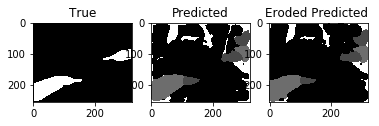

[epoch1] train_loss:0.87712 val_loss:0.80828
saving the model

EPOCH 2 of 200

Predicted Classes: [  0  64  96 224]
True Classes: [  0  32 128 160]


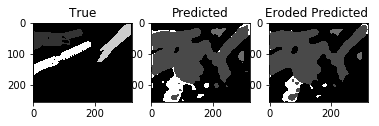

[epoch2] train_loss:0.76870 val_loss:0.84539

EPOCH 3 of 200

Predicted Classes: [  0  32  64  96 128 192 224]
True Classes: [  0 128 160]


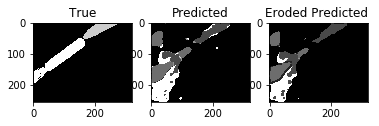

[epoch3] train_loss:0.71488 val_loss:0.70536

EPOCH 4 of 200

Predicted Classes: [  0  32  64  96 128 192 224]
True Classes: [ 0 96]


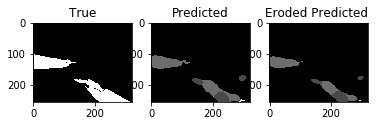

[epoch4] train_loss:0.70551 val_loss:0.67442

EPOCH 5 of 200

Predicted Classes: [  0  32  64  96 128 192 224]
True Classes: [ 0 96]


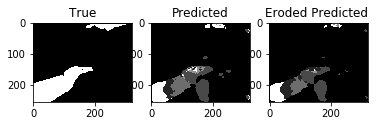

[epoch5] train_loss:0.69388 val_loss:0.71465

EPOCH 6 of 200

Predicted Classes: [  0  64  96 128 192 224]
True Classes: [ 0 64 96]


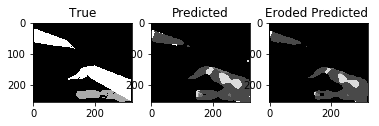

[epoch6] train_loss:0.67198 val_loss:0.70692

EPOCH 7 of 200

Predicted Classes: [  0  32  64  96 128 224]
True Classes: [ 0 64 96]


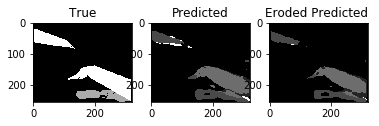

[epoch7] train_loss:0.65367 val_loss:0.66867

EPOCH 8 of 200

Predicted Classes: [  0  32  64  96 128 192 224]
True Classes: [ 0 96]


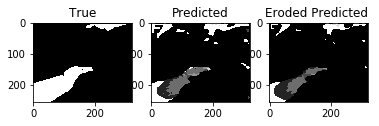

[epoch8] train_loss:0.64858 val_loss:0.72305

EPOCH 9 of 200

Predicted Classes: [  0  32  64  96 128 224]
True Classes: [  0  64 224]


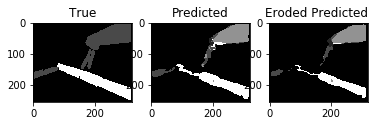

[epoch9] train_loss:0.64365 val_loss:0.73802

EPOCH 10 of 200

Predicted Classes: [ 0 32 64 96]
True Classes: [ 0 96]


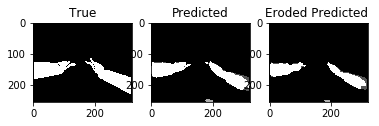

[epoch10] train_loss:0.62677 val_loss:0.64629

EPOCH 11 of 200

Predicted Classes: [ 0 32 64 96]
True Classes: [ 0 96]


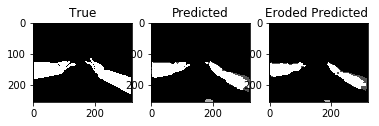

[epoch11] train_loss:0.62168 val_loss:0.63622
saving the model

EPOCH 12 of 200

Predicted Classes: [ 0 32 64 96]
True Classes: [ 0 96]


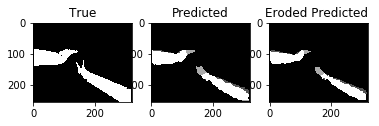

[epoch12] train_loss:0.60497 val_loss:0.65497

EPOCH 13 of 200

Predicted Classes: [  0  64 128 224]
True Classes: [  0  64 224]


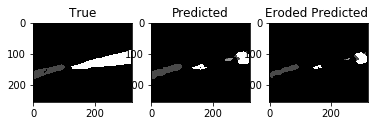

[epoch13] train_loss:0.60757 val_loss:0.63661

EPOCH 14 of 200

Predicted Classes: [ 0 32 64 96]
True Classes: [ 0 96]


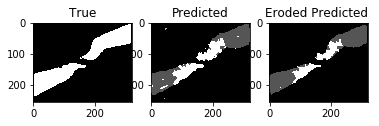

[epoch14] train_loss:0.60422 val_loss:0.64738

EPOCH 15 of 200

Predicted Classes: [  0  32  64  96 128 224]
True Classes: [  0 128 160]


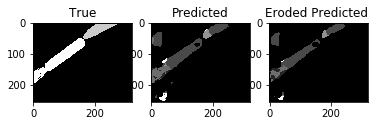

[epoch15] train_loss:0.59026 val_loss:0.61142

EPOCH 16 of 200

Predicted Classes: [  0  32  64  96 128 224]
True Classes: [  0  64 224]


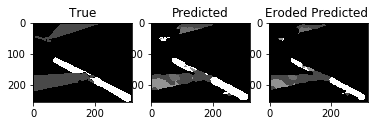

[epoch16] train_loss:0.61547 val_loss:0.61824

EPOCH 17 of 200

Predicted Classes: [  0  32  64  96 128]
True Classes: [ 0 96]


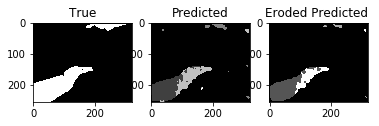

[epoch17] train_loss:0.60030 val_loss:0.61419

EPOCH 18 of 200

Predicted Classes: [  0  64 128 192 224]
True Classes: [  0  64 224]


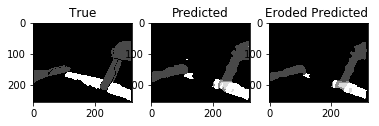

[epoch18] train_loss:0.58331 val_loss:0.61504

EPOCH 19 of 200

Predicted Classes: [  0  32  64  96 128]
True Classes: [ 0 96]


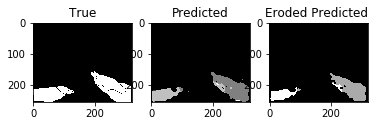

[epoch19] train_loss:0.58337 val_loss:0.58441

EPOCH 20 of 200

Predicted Classes: [  0  64  96 128 192 224]
True Classes: [  0  64 224]


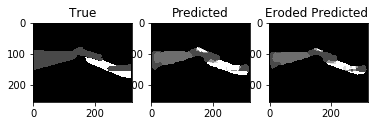

[epoch20] train_loss:0.57364 val_loss:0.56620

EPOCH 21 of 200

Predicted Classes: [  0  64 128 192 224]
True Classes: [  0  64 224]


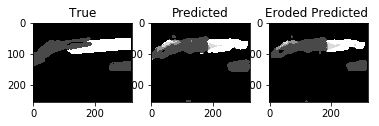

[epoch21] train_loss:0.57978 val_loss:0.56793
saving the model

EPOCH 22 of 200

Predicted Classes: [  0  32  64  96 128 224]
True Classes: [  0 128 160]


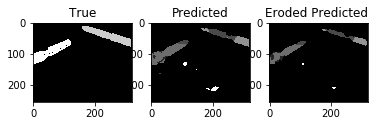

[epoch22] train_loss:0.57183 val_loss:0.55712

EPOCH 23 of 200

Predicted Classes: [  0  32  64  96 128]
True Classes: [ 0 64 96]


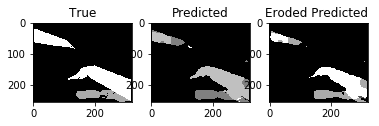

[epoch23] train_loss:0.55702 val_loss:0.55108

EPOCH 24 of 200

Predicted Classes: [  0  32  64  96 128 224]
True Classes: [  0  32 224]


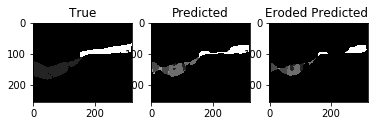

[epoch24] train_loss:0.55738 val_loss:0.56551

EPOCH 25 of 200

Predicted Classes: [  0  64  96 128 192 224]
True Classes: [  0  64 224]


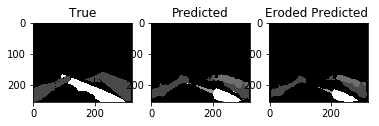

[epoch25] train_loss:0.56368 val_loss:0.55835

EPOCH 26 of 200

Predicted Classes: [  0  64  96 128 192 224]
True Classes: [  0  64 224]


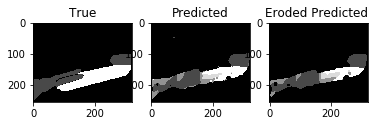

[epoch26] train_loss:0.55768 val_loss:0.55084

EPOCH 27 of 200

Predicted Classes: [  0  32  64  96 128 192 224]
True Classes: [  0  64 224]


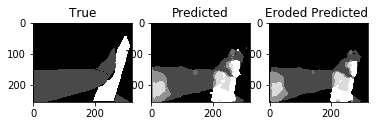

[epoch27] train_loss:0.55907 val_loss:0.54926

EPOCH 28 of 200

Predicted Classes: [  0  64  96 128 224]
True Classes: [  0  64 224]


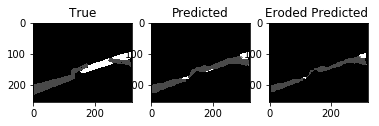

[epoch28] train_loss:0.56247 val_loss:0.55367

EPOCH 29 of 200

Predicted Classes: [  0  32  64  96 224]
True Classes: [ 0 96]


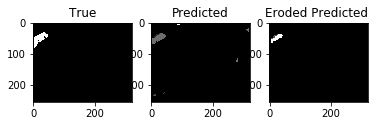

[epoch29] train_loss:0.54746 val_loss:0.54106

EPOCH 30 of 200

Predicted Classes: [  0  64  96 128 192 224]
True Classes: [  0  64 224]


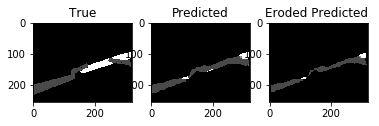

[epoch30] train_loss:0.54516 val_loss:0.54117

EPOCH 31 of 200

Predicted Classes: [  0  64  96 128 192 224]
True Classes: [  0  64 224]


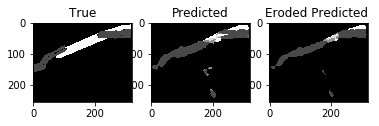

[epoch31] train_loss:0.53863 val_loss:0.55673
saving the model

EPOCH 32 of 200

Predicted Classes: [ 0 32 64 96]
True Classes: [ 0 96]


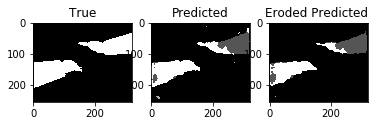

[epoch32] train_loss:0.54799 val_loss:0.56027

EPOCH 33 of 200

Predicted Classes: [ 0 32 64 96]
True Classes: [ 0 96]


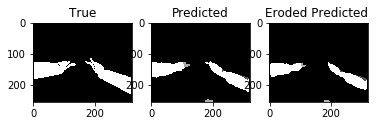

[epoch33] train_loss:0.54329 val_loss:0.54746

EPOCH 34 of 200

Predicted Classes: [  0  32  64  96 128 224]
True Classes: [ 0 96]


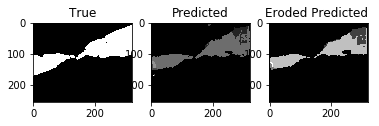

[epoch34] train_loss:0.55767 val_loss:0.53734

EPOCH 35 of 200

Predicted Classes: [  0  64  96 128 192 224]
True Classes: [  0  64 224]


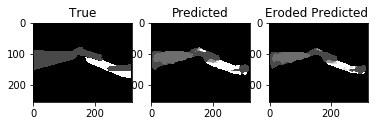

[epoch35] train_loss:0.56014 val_loss:0.54977

EPOCH 36 of 200

Predicted Classes: [  0  64  96 128 224]
True Classes: [  0 128 160]


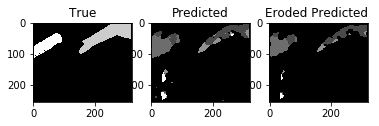

[epoch36] train_loss:0.52939 val_loss:0.54348

EPOCH 37 of 200

Predicted Classes: [ 0 32 64 96]
True Classes: [ 0 96]


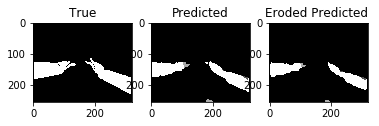

[epoch37] train_loss:0.55206 val_loss:0.53020

EPOCH 38 of 200

Predicted Classes: [  0  64  96 128 192 224]
True Classes: [  0  64 224]


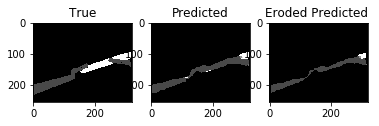

[epoch38] train_loss:0.54636 val_loss:0.54063

EPOCH 39 of 200

Predicted Classes: [  0  32  64  96 128]
True Classes: [ 0 96]


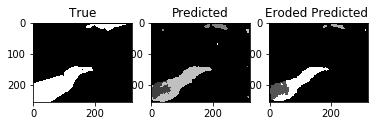

[epoch39] train_loss:0.54702 val_loss:0.52744

EPOCH 40 of 200

Predicted Classes: [  0  64  96 128 192 224]
True Classes: [  0  64 224]


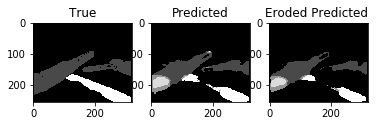

[epoch40] train_loss:0.54642 val_loss:0.55697

EPOCH 41 of 200

Predicted Classes: [  0  32  64  96 128 224]
True Classes: [  0  32 224]


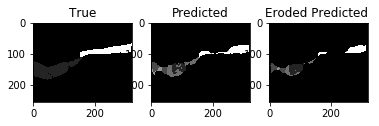

[epoch41] train_loss:0.54369 val_loss:0.55534
saving the model

EPOCH 42 of 200

Predicted Classes: [  0  32  64  96 128 224]
True Classes: [  0  32 224]


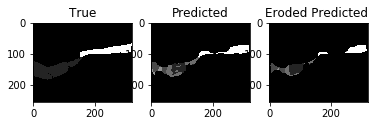

[epoch42] train_loss:0.54817 val_loss:0.55066

EPOCH 43 of 200

Predicted Classes: [  0  64  96 128 192 224]
True Classes: [  0  64 224]


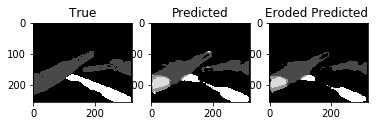

[epoch43] train_loss:0.54285 val_loss:0.53875

EPOCH 44 of 200

Predicted Classes: [  0  32  64  96 128 224]
True Classes: [  0  32 224]


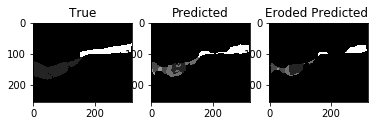

[epoch44] train_loss:0.53751 val_loss:0.54286

EPOCH 45 of 200

Predicted Classes: [  0  32  64  96 128 192 224]
True Classes: [  0  32  64 224]


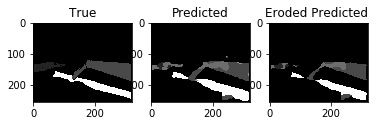

[epoch45] train_loss:0.55179 val_loss:0.56818

EPOCH 46 of 200

Predicted Classes: [  0  32  64  96 224]
True Classes: [ 0 96]


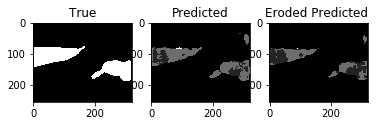

[epoch46] train_loss:0.54649 val_loss:0.53126

EPOCH 47 of 200

Predicted Classes: [ 0 32 64 96]
True Classes: [ 0 96]


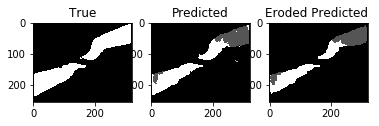

[epoch47] train_loss:0.55131 val_loss:0.54055

EPOCH 48 of 200

Predicted Classes: [  0  32  64  96 128 224]
True Classes: [ 0 96]


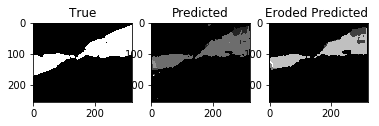

[epoch48] train_loss:0.55267 val_loss:0.53047

EPOCH 49 of 200

Predicted Classes: [  0  32  64  96 128]
True Classes: [ 0 96]


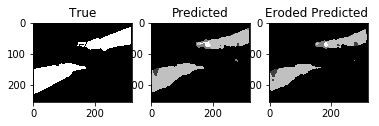

[epoch49] train_loss:0.54983 val_loss:0.54425

EPOCH 50 of 200

Predicted Classes: [  0  32  64  96 128]
True Classes: [ 0 96]


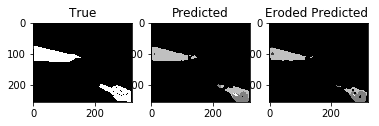

[epoch50] train_loss:0.55107 val_loss:0.57651

EPOCH 51 of 200

Predicted Classes: [  0  32  64  96 128]
True Classes: [ 0 96]


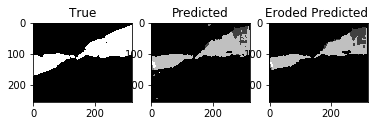

[epoch51] train_loss:0.53596 val_loss:0.56512
saving the model

EPOCH 52 of 200

Predicted Classes: [  0  32  64  96 224]
True Classes: [ 0 96]


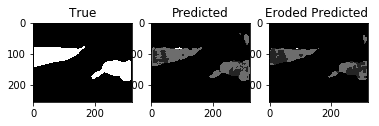

[epoch52] train_loss:0.54785 val_loss:0.53530

EPOCH 53 of 200

Predicted Classes: [  0  32  64  96 128 192]
True Classes: [ 0 96]


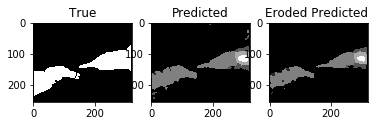

[epoch53] train_loss:0.54338 val_loss:0.53964

EPOCH 54 of 200

Predicted Classes: [  0  64  96 128 192 224]
True Classes: [  0  64 224]


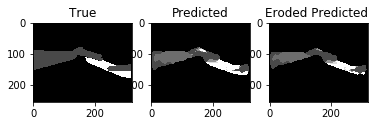

[epoch54] train_loss:0.55318 val_loss:0.54730

EPOCH 55 of 200

Predicted Classes: [  0  32  64  96 128]
True Classes: [ 0 96]


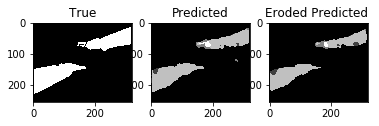

[epoch55] train_loss:0.53399 val_loss:0.57340

EPOCH 56 of 200

Predicted Classes: [  0  32  64  96 128]
True Classes: [ 0 96]


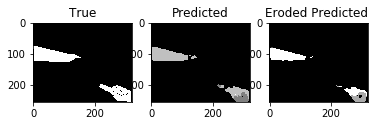

[epoch56] train_loss:0.54793 val_loss:0.54630

EPOCH 57 of 200

Predicted Classes: [  0  32  64  96 128]
True Classes: [ 0 96]


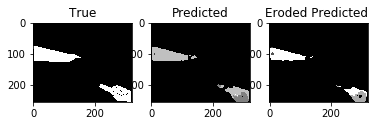

[epoch57] train_loss:0.54475 val_loss:0.53661

EPOCH 58 of 200

Predicted Classes: [ 0 32 64 96]
True Classes: [ 0 96]


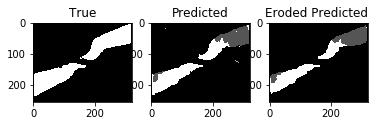

[epoch58] train_loss:0.54695 val_loss:0.55636

EPOCH 59 of 200

Predicted Classes: [  0  32  64  96 128 224]
True Classes: [ 0 96]


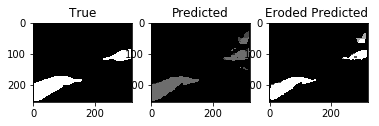

[epoch59] train_loss:0.54908 val_loss:0.55048

EPOCH 60 of 200

Predicted Classes: [ 0 32 64 96]
True Classes: [ 0 96]


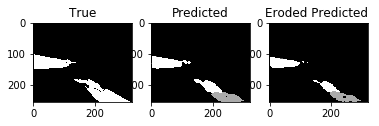

[epoch60] train_loss:0.55169 val_loss:0.55803

EPOCH 61 of 200

Predicted Classes: [  0  32  64  96 128]
True Classes: [ 0 96]


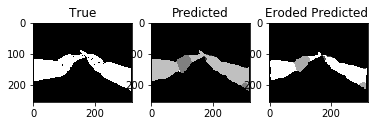

[epoch61] train_loss:0.55448 val_loss:0.54720
saving the model

EPOCH 62 of 200

Predicted Classes: [  0  32  64  96 128]
True Classes: [ 0 96]


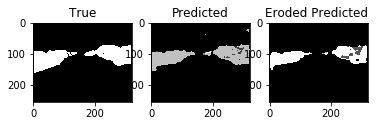

[epoch62] train_loss:0.54346 val_loss:0.54255

EPOCH 63 of 200

Predicted Classes: [  0  32  64  96 128 224]
True Classes: [  0  32 128]


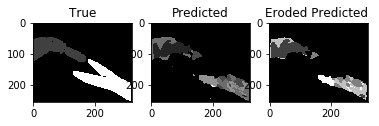

[epoch63] train_loss:0.54573 val_loss:0.54143

EPOCH 64 of 200

Predicted Classes: [  0  32  64  96 128 192]
True Classes: [ 0 96]


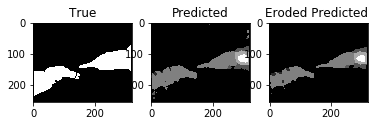

[epoch64] train_loss:0.55368 val_loss:0.54344

EPOCH 65 of 200

Predicted Classes: [ 0 32 64 96]
True Classes: [ 0 96]


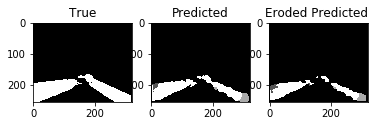

[epoch65] train_loss:0.55580 val_loss:0.58072

EPOCH 66 of 200

Predicted Classes: [  0  32  64  96 224]
True Classes: [ 0 64 96]


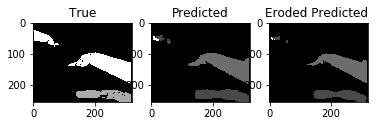

[epoch66] train_loss:0.55306 val_loss:0.56121

EPOCH 67 of 200



KeyboardInterrupt: ignored

In [24]:
import cv2
kernel = np.ones((5,5),np.uint8)


model = unet() # inital unet
if torch.cuda.is_available(): #use gpu if available
    print('using cuda')
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
print("Training Started!")
list_train_losses =[]
list_val_losses = []
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # Please design your own training section
    running_train_loss = 0.0
    scheduler.step()
    model.train()  # Set model to training mode
    for i_batch, sample_batched in enumerate(trainloader):
      # get the inputs
      inputs = sample_batched['image'] 
      labels = sample_batched['mask']
      
      # forward + backward + optimize
      outputs = model(inputs.cuda())
      loss = dice_loss(outputs.cuda(), labels.cuda())
      
      #Zero gradients (which accumulate) befrore running backward pass
      model.zero_grad()
      
      # Backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # Calling the step function on an Optimizer makes an update to its parameters
      optimizer.step()
      # record statistics
      running_train_loss += loss.item()
    ########################### Validation #####################################
    # Please design your own validation section
    with torch.no_grad():
      model.eval()   # Set model to evaluate mode
      running_val_loss = 0.0
      for i, val_sample_batched in enumerate(valloader):
          # get the inputs
          inputs = val_sample_batched['image'] 
          labels = val_sample_batched['mask']
          outputs = model(inputs.cuda())
          #val_loss = criterion(outputs.cuda(), labels.cuda())
          val_loss = loss = dice_loss(outputs.cuda(), labels.cuda())
          running_val_loss += val_loss.item()
          #visualization last batch of first output mask in val
          if i ==0:
            outputs_array = outputs.cpu().numpy()
            masks_array = labels.cpu().numpy()
            output=np.squeeze(outputs_array[0])
            mask = np.squeeze(masks_array[0])
            # reverse one-hot encoding
            output = reverse_one_hot_encoding(output)
            mask = reverse_one_hot_encoding(mask)
            print('Predicted Classes:',np.unique(output))
            print('True Classes:',np.unique(mask))
            plt.subplot(1,3,1)
            plt.imshow(mask,cmap="gray")
            plt.title('True')
            plt.subplot(1,3,2)
            plt.imshow(output,cmap="gray")
            plt.title('Predicted')
            plt.subplot(1,3,3)
            plt.imshow(cv2.erode(output.astype('uint8'),kernel,iterations = 1),cmap="gray")
            plt.title('Eroded Predicted ')
  
            plt.show()
            
    print('[epoch%d] train_loss:%.5f val_loss:%.5f' %(epoch + 1, running_train_loss/len(trainloader),running_val_loss/len(valloader)))
    #record losses
    list_train_losses.append(running_train_loss/len(trainloader))
    list_val_losses.append(running_val_loss/len(valloader))
    if epoch % 10 == 0:     # every 10 epoches save model
      print('saving the model')
      file_name = '/content/gdrive/My Drive/[epoch%d]_ir_.pth' %(epoch) 
      torch.save(model.state_dict(), file_name)
          

# Test


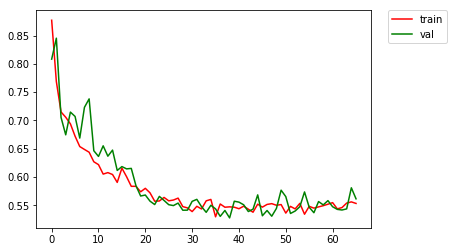

In [25]:
import matplotlib.patches as mpatches
plt.plot(list_train_losses,'-r',label='train')
plt.plot(list_val_losses,'-g',label='val')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

[ 0 32 64 96]
[ 0 96]


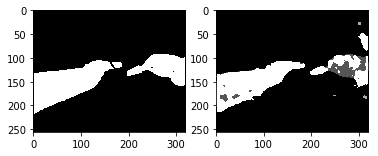

Average Dice Score for testset 0.26046348571777345


In [26]:
model = unet().cuda()
model.load_state_dict(torch.load('/content/gdrive/My Drive/[epoch50]_ir_.pth'))
with torch.no_grad():
      model.eval()   # Set model to evaluate mode
      running_dice_score = 0.0
      for i, val_sample_batched in enumerate(testloader):
          # get the inputs
          inputs = val_sample_batched['image'] 
          labels = val_sample_batched['mask']
          outputs = model(inputs.cuda())
          dice_score = 1- dice_loss(outputs.cuda(), labels.cuda())
          #val_loss = dice_loss(labels.cuda(),outputs.cuda()) 
          running_dice_score += dice_score.item()
          if i ==1:
            #visualization one test sample
            outputs_array = outputs.cpu().numpy()
            masks_array = labels.cpu().numpy()
            output=np.squeeze(outputs_array[0])
            mask = np.squeeze(masks_array[0])
            # reverse one-hot encoding
            output = reverse_one_hot_encoding(output)
            mask = reverse_one_hot_encoding(mask)
            print(np.unique(output))
            print(np.unique(mask))
            plt.subplot(1,2,1)
            plt.imshow(mask,cmap="gray")
            plt.subplot(1,2,2)
            plt.imshow(output,cmap="gray")
            plt.show()
      print('Average Dice Score for testset',running_dice_score/len(testloader))

In [0]:


def inference(input_img,path='/content/gdrive/My Drive/[epoch50]_ir_.pth'):
  '''
  input: input_img is a RGB image
         path is where saved checkpint
  
  output: out_img is a gray scale image
  '''
  #Initailza Unet for Segmentation
  if torch.cuda.is_available(): #use gpu if available
    print('using cuda')
    model = model.cuda()
  model = unet()
  model.load_state_dict(torch.load(path))
  with torch.no_grad():
      model.eval()   # Set model to evaluate mode
      input_img = cv2.resize(img, dsize=(256, 320), interpolation=cv2.INTER_CUBIC)
      input_img = input_img.transpose((2, 0, 1))
      input=torch.from_numpy(input_img).type(torch.FloatTensor) #change to float torch tensor
      outputs = model(inputs.cuda())
      outputs_array = np.squeeze(outputs.cpu().numpy())
      output = reverse_one_hot_encoding(output)
  
  return output
  
  
  